# Static plotting for `spatialdata` 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

⚠️ Adjust the variable below to the data path on your specific workstation.

In [1]:
# %load_ext jupyter_black

data_path = "../data/"

In [4]:
import spatialdata as sd
import spatialdata_plot as sdp
import matplotlib.pyplot as plt  # for multi-panel plots later
import scanpy as sc
import squidpy as sq

for p in [sd, sdp, sc, sq]:
    print(f"{p.__name__}: {p.__version__}")

sdata_visium = sd.read_zarr(data_path + "visium.zarr/")

/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


spatialdata: 0.4.0
spatialdata_plot: 0.2.10
scanpy: 1.11.1
squidpy: 1.6.5


In particular, the library exposes the following functions:
- [`SpatialData.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images)
- [`SpatialData.pl.render_labels()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_labels)
- [`SpatialData.pl.render_points()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_points)
- [`SpatialData.pl.render_shapes()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_shapes)
- [`SpatialData.pl.show()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.show)

We can chain the 4 `render_xxx` functions to gradually build up a figure, with a final call to `show` to then actually render out the function. In the following sections we will explore these functions further.

## Simple function calls <a id="simple-viz"></a>
Let's first focus on some [Visium](https://www.10xgenomics.com/products/spatial-gene-expression) data from the previous notebook. As we can see below, it contains slots for `Images`, `Shapes`, and `Tables`.

In [5]:
sdata_visium

SpatialData object, with associated Zarr store: /Users/malbert/teaching/202505_Pasteur_Neubias/Pasteur-BioImage-Analysis-Course-2025/Analyst/Day3/spatialdata/data/visium.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_downscaled_hires', with elements:
        C

Let's first visualize the individual contained modalities separately. When rendering the images, we see that we get two plots. That's because the `SpatialData` object contains two coordinate systems (`downscaled_hires` and `downscaled_lowres`) with images aligned to them. The `global` coordinate system doesn't contain any, as visible above.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


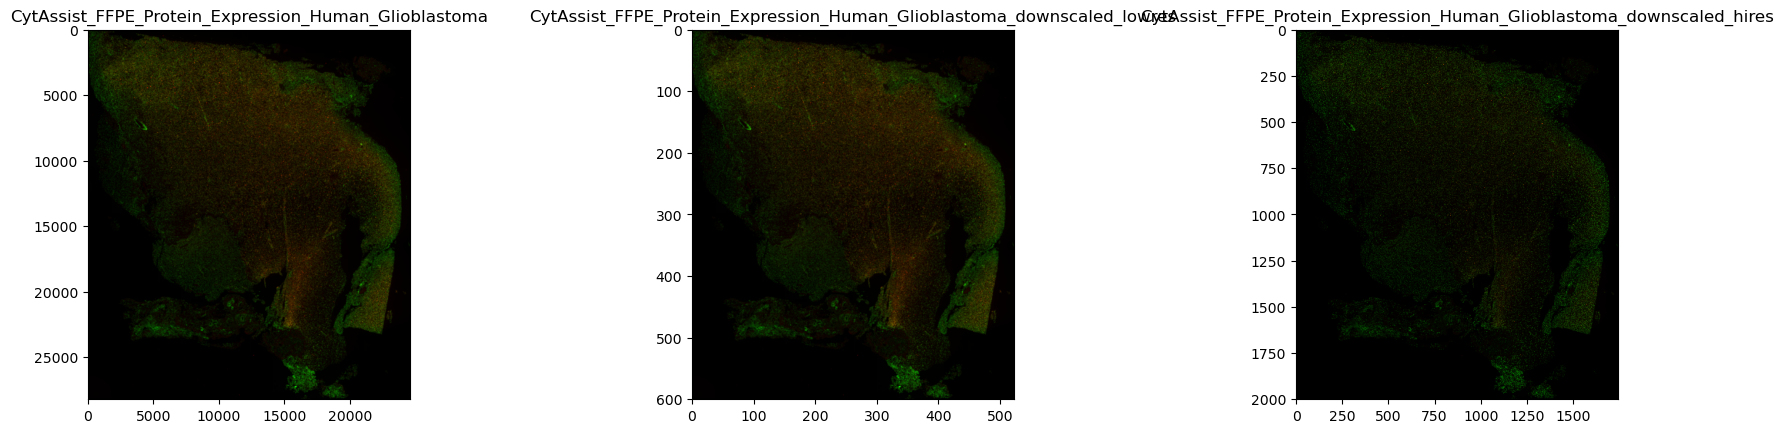

In [6]:
sdata_visium.pl.render_images().pl.show()

We can pass the name of a specific coordinate system to the `pl.show()` function to only render elements of that coordinate system.

INFO     Rasterizing image for faster rendering.                                                                   


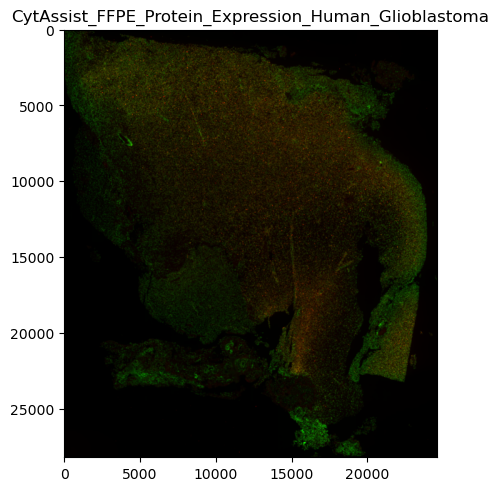

In [8]:
sdata_visium.pl.render_images().pl.show(coordinate_systems="CytAssist_FFPE_Protein_Expression_Human_Glioblastoma")

The Visium technology works by detecting transcripts in specific circular caption locations (often referred to as "Visium spots") on a slide. The circular capture locations are defined by the `Shapes` slot, which contains their coordinates. The `Tables` slot contains the actual transcript counts for each capture location. We can use the `render_shapes` function to overlay these circular locations onto our image.

![Visium technology](../resources/visium_tech.png)

_Image: The Visium Spatial Gene Expression Slide (https://www.10xgenomics.com/)_

INFO     Rasterizing image for faster rendering.                                                                   


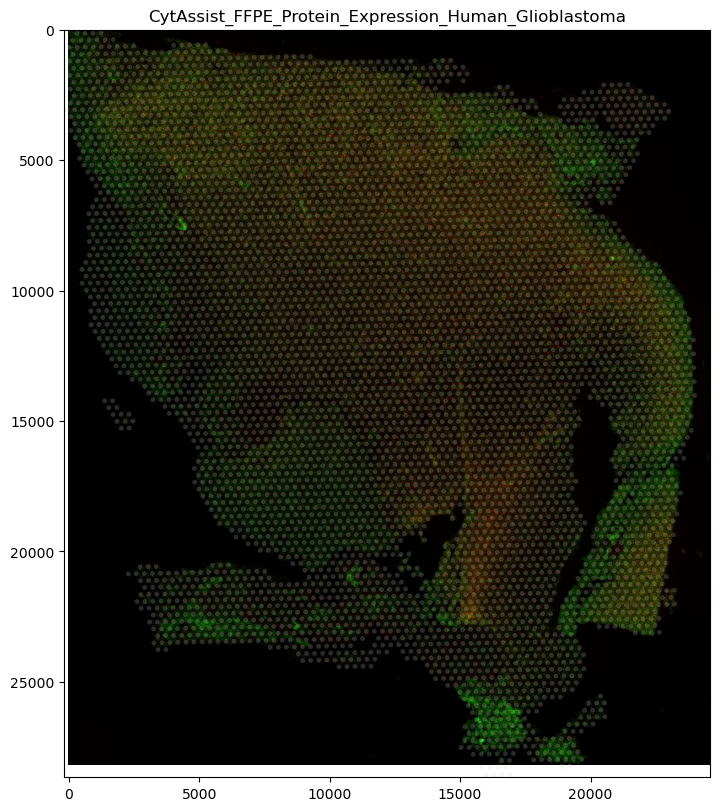

In [10]:
(
    sdata_visium.pl.render_images()
    .pl.render_shapes(fill_alpha=0.2)
    .pl.show("CytAssist_FFPE_Protein_Expression_Human_Glioblastoma", figsize=(8, 8))
)

## Identify some genes with spatial patterns
However, simply overlaying these locations doesn't really contain much information. Ideally we want to investigate spatial trends in the gene expression data. For this we're going to use `Squidpy`, another scverse package that contains several spatial analysis tools. We'll use it to calculate the spatial autocorrelation of some genes, more specifically Moran's I. This measure describes how homogenous a gene is expressed across a slide:

![spatial patterns](../resources/spatial_patterns.png)

_Image: https://en.wikipedia.org/wiki/Moran%27s_I_

In [11]:
adata_visium = sdata_visium.table

sq.gr.spatial_neighbors(adata_visium)
sq.gr.spatial_autocorr(
    adata_visium,
    mode="moran",
    genes=adata_visium.var_names,
    n_perms=10,
    n_jobs=1,
)

/var/folders/fb/ccf_crrx195fclngv32r4xcc0000gq/T/ipykernel_38595/829487675.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata_visium = sdata_visium.table
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/scanpy/metrics/_common.py:72: UserWarning: 43 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?/s]

/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/scanpy/metrics/_common.py:72: UserWarning: 43 variables were constant, will return nan for these.
  warnings.warn(
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [13]:
print(adata_visium.uns["moranI"])

                   I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
CST3        0.925848        0.0  0.000061         0.0  0.090909  0.000202   
GFAP        0.907449        0.0  0.000061         0.0  0.090909  0.000125   
IFI6        0.903449        0.0  0.000061         0.0  0.090909  0.000161   
PTPRZ1      0.901717        0.0  0.000061         0.0  0.090909  0.000169   
SPARC       0.900480        0.0  0.000061         0.0  0.090909  0.000093   
...              ...        ...       ...         ...       ...       ...   
NLGN4Y           NaN        NaN  0.000061         NaN  0.090909       NaN   
AC007244.1       NaN        NaN  0.000061         NaN  0.090909       NaN   
KDM5D            NaN        NaN  0.000061         NaN  0.090909       NaN   
EIF1AY           NaN        NaN  0.000061         NaN  0.090909       NaN   
DAZ2             NaN        NaN  0.000061         NaN  0.090909       NaN   

            pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
CST3    

In [14]:
print(adata_visium.uns["moranI"].head(3))
print(abs(adata_visium.uns["moranI"][~adata_visium.uns["moranI"]["I"].isna()]).tail(3))

             I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
CST3  0.925848        0.0  0.000061         0.0  0.090909  0.000202   
GFAP  0.907449        0.0  0.000061         0.0  0.090909  0.000125   
IFI6  0.903449        0.0  0.000061         0.0  0.090909  0.000161   

      pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
CST3               NaN                NaN         0.107675  
GFAP               NaN                NaN         0.107675  
IFI6               NaN                NaN         0.107675  
                I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
FAM81B   0.012231   0.061272  0.000061    0.008293  0.090909  0.000018   
FOXD3    0.012730   0.053913  0.000061    0.013298  0.090909  0.000027   
COLEC10  0.013522   0.043683  0.000061    0.010217  0.090909  0.000035   

         pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
FAM81B                NaN                NaN         0.107675  
FOXD3                 NaN                NaN  

Let's visualise the spatial expression of the 3 genes with the highest and lowest Moran's I scores each. We'll use classic matplotlib synthax to construct the multi-panel figure.

INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


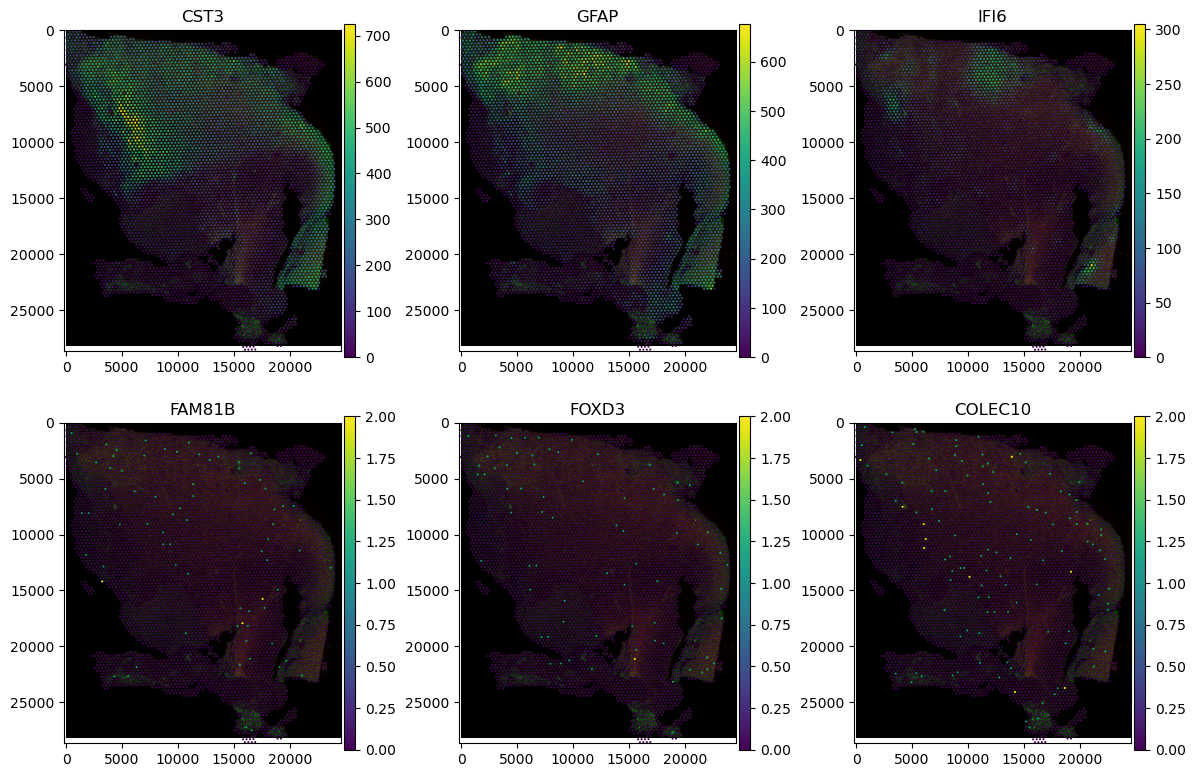

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for idx, gene in enumerate(["CST3", "GFAP", "IFI6", "FAM81B", "FOXD3", "COLEC10"]):
    (
        sdata_visium.pl.render_images()
        .pl.render_shapes(color=f"{gene}")
        .pl.show("CytAssist_FFPE_Protein_Expression_Human_Glioblastoma", ax=axs[idx // 3, idx % 3], title=gene)
    )

fig.tight_layout()

Generally, the `spatialdata-plot` library tries to be as flexible as possible, allowing for a wide range of different plotting options. However, this flexibility comes at the cost of some complexity. To limit the amount of permutations we have to account for in the codebase, we recommend a workflow in which one gradually builds up a figure on an `ax` object. If multiple similar plots are required, it is currently the easiest way, to manually assign them to their panels, for example like this:

INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


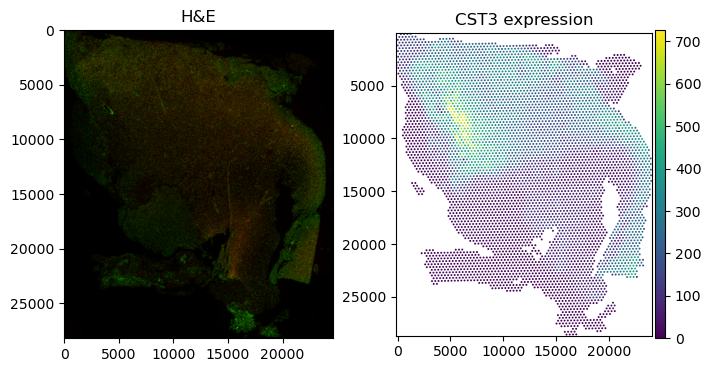

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sdata_visium.pl.render_images().pl.show(
    "CytAssist_FFPE_Protein_Expression_Human_Glioblastoma", ax=axs[0], title="H&E")

sdata_visium.pl.render_shapes(color="CST3").pl.show(
    "CytAssist_FFPE_Protein_Expression_Human_Glioblastoma", ax=axs[1], title="CST3 expression"
)